# The Hydrogen atom

*Note: This is the third of a series of three jupyter notebooks. Generic explanations are given along with the code; however, for a more thorough explanation of the techniques used please visit the first notebook (linked next). The first and second notebooks can be found at this [GitHub repository](https://github.com/javier-rozalen/AJP-Article).*

Here we solve the Hydrogen atom in 1D using the NQS method. The full 3D Hamiltonian in spherical coordinates $(r,\theta,\varphi)$ reads:

$$\hat{H}=-\frac{\hbar^2}{2\mu}\bigg\{ \frac{1}{r^2}\frac{\partial}{\partial r}\bigg(r^2\frac{\partial}{\partial r}\bigg)+\frac{1}{r^2}\bigg[\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\bigg(\sin\theta\frac{\partial}{\partial\theta}\bigg)+\frac{1}{\sin^2\theta}\frac{\partial^2}{\partial\phi^2}\bigg]\bigg\}-\frac{Ze^2}{r},$$

where $\mu$ is the reduced mass of the system, $Z$ is the atomic number ($Z=1$ for Hydrogen), $\hbar$ is the reduced Planck constant and $e$ is the electrical charge of the electron. Here, the standard "next step" is to employ the definition of angular momentum,

$$ L^2=-\hbar^2 \bigg[\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\bigg(\sin\theta\frac{\partial}{\partial\theta}\bigg)+\frac{1}{\sin^2\theta}\frac{\partial^2}{\partial\phi^2}\bigg],$$

and then seize the fact that $[H_r,L^2]=[H_r,L_z]=[L^2,L_z]=0$ to write our wave functions in a factorized manner: $\psi_{nlm}(r,\theta,\varphi)=R_{nl}(r)Y_{lm}(\theta,\varphi)$, where $Y_{lm}(\theta,\varphi)$ are the spherical harmonics. This is useful because the spherical harmonics are eigenstates of $L^2$ with eigenvalues $l(l+1)\hbar^2$, and this allows us to rewrite our Hamiltonian as follows:

$$\hat{H}=-\frac{\hbar^2}{2\mu}\frac{1}{r^2}\frac{\partial}{\partial r}\bigg(r^2\frac{\partial}{\partial r}\bigg)+\frac{l(l+1)\hbar^2}{2\mu r^2}-\frac{Ze^2}{r^2}.$$

This last result important because it tells us that we can write the Hamiltonian for a given $l$ as only depending on $r$, so at this point we are effectively dealing with a 1D problem. We now introduce the usual definition of the "reduced (radial) functions":

$$ R_{nl}(r)\equiv\frac{P_{nl}(r)}{r}. $$

It is also important to work in *atomic units*, defined by the relations: $m_e=e=\hbar=1$, where $m_e$ is the mass of the electron. This, along with the approximation $\mu\approx m_e$ leads us to the final expression for the Hamiltonian (in atomic units):

$$\hat{H}=-\frac{1}{2}\frac{d^2}{dr^2}+\frac{l(l+1)}{2r^2}-\frac{Z}{r}.$$

## Imports
We start our code by importing the necessary modules.

In [1]:
# Imports
%matplotlib notebook
import torch, time
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

## General parameters

We define the various parameters and hyperparameters.

In [2]:
# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 4  # Nodes in the hidden layer
a = 0.5 # envelope width

# Physical parameters
Z = 1
l = 0

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Training hyperparameters
epochs = 1000
lr = 1e-2  # Learning rate

# Mesh parameters
Nr = 10000                    # Mesh division
train_a = 0                     # Mesh lower limit
train_b = 20                        # Mesh upper limit
h = (train_b - train_a) / (Nr - 1)  # Mesh parameter "h"
Q_train = torch.linspace(train_a+h, train_b, Nr, requires_grad=True, device=device)      

## Obtaining the benchmark functions

The Hydrogen atom, although mathematically involved, can be solved analytically. The general form of the solutions is long, but since we are only concerned with the radial coordinate $r$, we will write the form of some functions $P_{nl}(r)$ for some values of $n, l$:

$$ P_{10}(r) = 2Z^{3/2}re^{-Zr}, $$

$$ P_{20}(r) = \frac{1}{\sqrt{2}}Z^{3/2}r\bigg(1-\frac{1}{2}Zr\bigg)e^{-Zr/2}, $$

etc. Below is a simple Python implementation for these functions that we shall later use for benchmarking purposes.

<IPython.core.display.Javascript object>


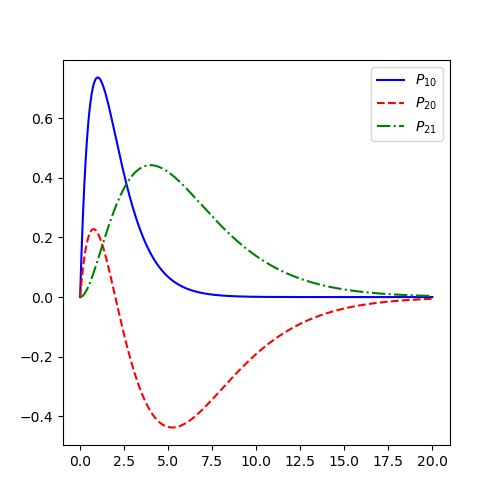

In [3]:
P_10 = lambda r : 2.*np.power(Z, 1.5)*r*np.exp(-Z*r)
P_20 = lambda r : (1/np.sqrt(2.))*np.power(Z, 1.5)*r*(1-0.5*Z*r)*np.exp(-Z*r/2.)
P_21 = lambda r : (1/(2*np.sqrt(6.)))*np.power(Z, 2.5)*np.power(r, 2)*np.exp(-Z*r/2.)
E0_th = -0.5
E1_th = -1./8

r_grid = np.linspace(train_a, train_b, Nr)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.plot(r_grid, P_10(r_grid), color='b', label='$P_{10}$')
ax.plot(r_grid, P_20(r_grid), color='r', linestyle='--', label='$P_{20}$')
ax.plot(r_grid, P_21(r_grid), color='g', linestyle='-.', label='$P_{21}$')
ax.legend()
fig.canvas.draw()
time.sleep(0.1)

Now we compute the error we are introducing by starting our grid at $h$ instead of $0$. We compute this as the energy from $0$ to $h$ using the analytical solution. 

In [4]:
dP_10_dr = lambda r : 2*np.power(Z, 1.5)*np.exp(-Z*r)*(1-Z*r)
deltaE = lambda r : h * (0.5*np.power(dP_10_dr(r), 2) + np.power(P_10(r), 2)*(l*(l+1)/(2*r**2)-Z/r)).sum()
#deltaE(np.linspace(1e-20, h))
overlap = lambda r : (P_10(r)*P_20(r)).sum()*h
overlap(np.linspace(0., 20, 10000))

3.520445534873675e-10

## The neural network

We now create the neural network. The architecture is the same as that used for the HO, and therefore so is the code implementation.

In [5]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o
    
net = HarmonicNQS(W1, B, W2).to(device)

## The optimizer

As in the first notebook, we use RMSprop as our optimizer. We can define our RMSprop optimizer in a single line of code:

In [6]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

## The loss function

The loss function is computed in much the same fashion as for the HO and the DW cases, this is,

$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}}{\bra{\psi_\theta}\psi_\theta\rangle}. $$

Because we are working in polar coordinates and given that the interaction is Coulomb-like, the integrals above 

$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta} = \int_0^\infty \bigg\{\frac{1}{2}\bigg(\frac{dP_{nl}(r)}{dr}\bigg)^2+P_{nl}^2(r)\bigg[\frac{l(l+1)}{2r^2}-\frac{Z}{r}\bigg]\bigg\}dr $$

With the usual discretisation these are written: 
$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta} \approx \sum_{i=1}^{N_r} w_i \bigg[\frac{1}{2}\bigg(\frac{dP_{nl}(r_i)}{dr}\bigg)^2+P_{nl}^2(r_i)\bigg(\frac{l(l+1)}{2r_i^2}-\frac{Z}{r_i}\bigg)\bigg], $$

$$\bra{\psi_\theta}\psi_\theta\rangle\approx \sum_{i=1}^{N_x} w_i \psi_\theta^2(x_i)\equiv N.$$

The code implementation is, then:

In [7]:
def loss_fn():  
    X_pot = X.clone().detach()
    psi = net(X)*X.pow(l+1) 
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = h * psi2.sum()                 
    U = h * (psi2 * ( l*(l+1)/(2*X_pot.pow(2)) - Z/X_pot )).sum() / N  
    K = h * (1/2) * dpsi_dx.pow(2).sum() / N
    E = K + U   
    
    return E, U, K, psi, psi / torch.sqrt(N) 

In [8]:
h

0.002000200020002

## Plotting

We set the function that does the plots periodically. Please note that the syntax is slightly more intricate than strictly necessary; this is intended to improve the final visualization of the plots in a jupyter notebook environment.

In [9]:
def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf = psi_normalized.detach().numpy()
    ax1.set_ylim(np.min(wf), np.max(wf)*1.1)
    #if np.max(wf) < 0: wf = -wf
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(r_grid)
        ax1.lines[1].set_ydata(target)
        ax1.lines[2].set_xdata(r_grid)
        ax1.lines[2].set_ydata(np.power(r_grid, l+1))
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(r_grid, target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.plot(r_grid, np.power(r_grid, l+1), linestyle='--', color='g', label='Envelope')
        ax1.legend()
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    wf = psi.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf 
    #ax2.set_ylim(-0.05, maxwf*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    """
    if loss[-1] <= 0:
        ax3.set_ylim(loss[-1]*1.1, E0_th*1.1)
    else:
        ax3.set_ylim(E0_th*1.1, loss[-1]*1.1)
    """
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*E0_th][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)*E0_th, linestyle='--', label='$E_0$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: ground state, $\ket{\psi_0}$

The training is carried out in the exact same manner as for the HO. Below is the code implementation.

<IPython.core.display.Javascript object>


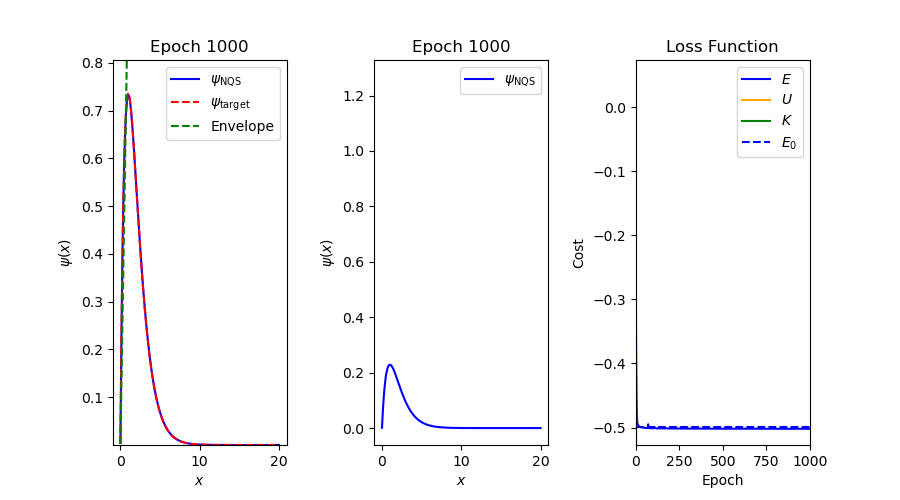

Training the NQS...: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.91it/s]


In [10]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
#ax3.set_ylim(0, 2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)
r_grid = Q_train.clone().detach().numpy()
if l == 0:
    target = P_10(r_grid)
elif l == 1:
    target = P_21(r_grid)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.1)

E0, psi0 = loss_accum[-1], psi.clone().detach()

*Note: When running the above cell more than once, please take into account that the network is already trained from the first run. To restart the training from scratch, first re-run the code cells of sections [General parameters](#General-parameters), [The neural network](#The-neural-network) and [The optimizer](#The-optimizer).*

## Training the network: first excited state, $\ket{\psi_1}$

We now go for the first excited state. As explained in the main article and in the HO notebook [include link], we want to make $\psi_1$ antisymmetric (given that $\psi_0$ is symmetric),

$$ \psi_{\theta',1}(x) \longleftarrow \psi_{\theta',1}(x)-\psi_{\theta',1}(-x) .$$

In [11]:
def loss_fn_prime(l):  
    X_pot = X.clone().detach()
    psi = net1(X)*X.pow(l+1)
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    # Energy term
    N = h * psi2.sum()                       
    U = h * (psi2 * ( l*(l+1)/(2*X_pot.pow(2)) - Z/X_pot )).sum() / N  
    K = h * (1/2) * dpsi_dx.pow(2).sum() / N
    E = K + U    
    
    # Overlap term
    num = (h * (psi*psi0).sum()).pow(2)
    den = (h * psi2.sum()) * (h * psi0.pow(2).sum())
    O = lambda_ * (num / den).pow(2)
    
    # Total loss
    L = E + O
    
    return L, U, K, psi, psi / torch.sqrt(N) 

Now we define a new neural network, which has the exact same architecture as the one used for the ground state. We can do this by creating a new instance of our [previous NQS](#The-neural-network). We also reset the optimizer parameters by redefining it. 

In [12]:
# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 10  # Nodes in the hidden layer

l = 0

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients
lr = 5e-2
lambda_ = 20.

net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)
epochs = 10000

We define a new plotting function,

In [13]:
def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf = psi_normalized.detach().numpy()
    maxwf = np.max(wf)
    #if net1(torch.tensor([5.])).item() < 0.: wf *= -1
    ax1.set_ylim(np.min(wf)*1.1, maxwf*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(r_grid)
        ax1.lines[1].set_ydata(target)
        ax1.lines[2].set_xdata(r_grid)
        ax1.lines[2].set_ydata(np.power(r_grid, l+1))
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(r_grid, target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.plot(r_grid, np.power(r_grid, l+1), color='g', linestyle='-.', label='Envelope')
        ax1.plot()
        ax1.legend()
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    wf = psi.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf 
    ax2.set_ylim(np.min(wf)*1.1, maxwf*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*E1_th][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)*E1_th, linestyle='--', label='$E_1$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

Now we are ready to train our ansatz $\psi_{\theta',1}=\langle x | \psi_{\theta',1}\rangle$.

<IPython.core.display.Javascript object>


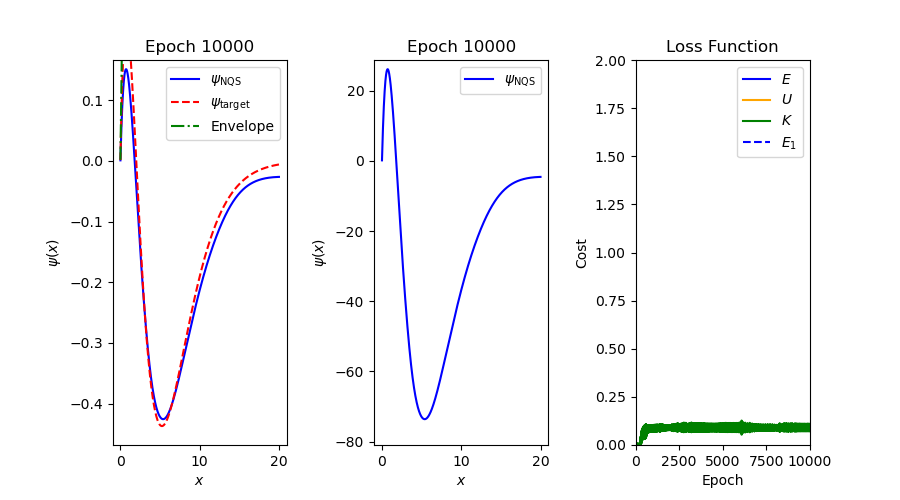

Training the NQS...: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.06it/s]


In [14]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)
r_grid = Q_train.clone().detach().numpy()
if l == 0:
    target = P_20(r_grid)
elif l == 1:
    target = P_21(r_grid)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss1, U, K, psi, psi_normalized = loss_fn_prime(l)    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 500 == 0): # We plot periodically
        pic(i, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.1)
        
E1, psi1 = loss_accum[-1], psi

## Extra: Computation Graph

Using the Python library found at this [GitHub repository](https://github.com/szagoruyko/pytorchviz) we construct the computation graph for the ground state. 

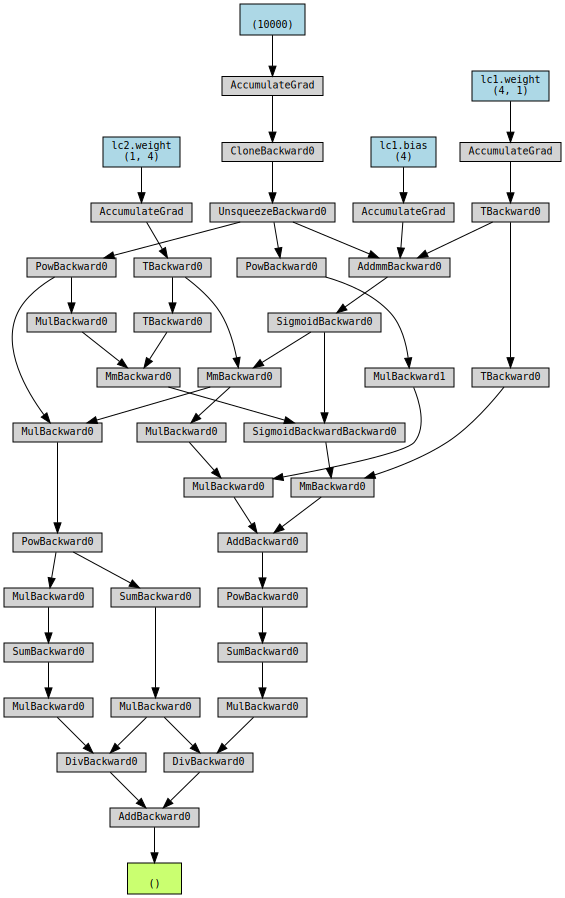

In [15]:
# Imports
from torchviz import make_dot 

make_dot(loss0, params=dict(list(net.named_parameters())))

The reader can easily check that, starting from the *leaves* of the tree (blue boxes at the top), all operations manually performed to these leave tensors appear in the graph in an ordered fashion. The graph additionally contains operations which are applied automatically by PyTorch, such as ```TBackward``` (transpose backward), which are necessary for the correct functioning of the code. 

The green box at the very bottom is called the *root* of the tree, and it represents the tensor w.r.t. which the gradients are computed, generally the loss function. 

Simply put, this purpose of this graph is to indicate to the ```autograd``` engine the order in which the chain rule is to be applied in the backpropagation of the error to the network parameters. Further explanations on this matter can fe bound at the official PyTorch site: [How Computational Graphs are Constructed in PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/).